In [1]:
from nbodykit.lab import *
from nbodykit import style, setup_logging

import corner
from tqdm import tqdm
import numpy as np
import seaborn as sns
import MAS_library as MASL
import Pk_library as PKL
import matplotlib.pyplot as plt

import sys, pickle, time, os
# sys.path.insert(1, './')
from run_nbk_dict import COSMOPAR, order_dimension, order_folders, cosmological_pars, \
                         VarCosmoPar, fiducial_vals
from run_nbk_funcs import cosmo_parser, PacMan, Hartlap, error_message

# nbodykit tool to read custom (non-standard) catalogue file type
from nbodykit.io.base import FileType
# nbodykit tool to creae custom subclass od CatalogSource
from nbodykit.source.catalog.file import FileCatalogFactory
from nbodykit.source.catalog import BinaryCatalog
# nbodykit cosmology parameters initialization
from nbodykit.lab import cosmology, FFTPower

from readfof import FoF_catalog
from torch import flatten, from_numpy

/home/fuffolo97/anaconda3/envs/nbodykit-envB/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
number_coeff_pk = 320
files_to_proecss = os.listdir('./Pk-files/')

In [3]:
nfile_fiducial, nfile_fiducial_rsd = "a", "a"
nfile_fiducial_no_W, nfile_fiducial_rsd_no_W = "a", "a"

for i in range(len(files_to_proecss)):
    fn = files_to_proecss[i]
    if ("fiducial" in fn) and ("rsd" not in fn) and ("W" not in fn): nfile_fiducial = fn
    if ("fiducial" in fn) and ("rsd"     in fn) and ("W" not in fn): nfile_fiducial_rsd = fn
    if ("fiducial" in fn) and ("rsd" not in fn) and ("W" not in fn): nfile_fiducial_no_W = fn
    if ("fiducial" in fn) and ("rsd"     in fn) and ("W" not in fn): nfile_fiducial_rsd_no_W = fn

assert type(nfile_fiducial) == type(nfile_fiducial_rsd) == str

fiducial_pk = []
fiducial_rsd_pk = []
fiducial_pk_no_W = []
fiducial_rsd_pk_no_W = []

with open("./Pk-files/"+nfile_fiducial, "rb") as f:
    while True:
        try:
            fiducial_pk.append(pickle.load(f))
        except EOFError:
            break

with open("./Pk-files/"+nfile_fiducial_rsd, "rb") as f:
    while True:
        try:
            fiducial_rsd_pk.append(pickle.load(f))
        except EOFError:
            break

with open("./Pk-files/"+nfile_fiducial_no_W, "rb") as f:
    while True:
        try:
            fiducial_pk_no_W.append(pickle.load(f))
        except EOFError:
            break

with open("./Pk-files/"+nfile_fiducial_rsd_no_W, "rb") as f:
    while True:
        try:
            fiducial_rsd_pk_no_W.append(pickle.load(f))
        except EOFError:
            break

In [113]:
fiducial_pk[0].attrs["shotnoise"]

9936.32529423442

In [111]:
fiducial_pk_pk, fiducial_rsd_pk_pk = [], []
for i in range(len(fiducial_pk)):
    fiducial_pk_pk.append(fiducial_pk[i]["power"].real  )# - fiducial_pk[i].attrs['shotnoise'] )
    fiducial_rsd_pk_pk.append(fiducial_rsd_pk[i]["power"].real )# - fiducial_rsd_pk[i].attrs['shotnoise'] )

fiducial_pk_pk_no_W, fiducial_rsd_pk_pk_no_W = [], []
for i in range(len(fiducial_pk)):
    fiducial_pk_pk_no_W.append(fiducial_pk_no_W[i]["power"].real )# - fiducial_pk[i].attrs['shotnoise'] )
    fiducial_rsd_pk_pk_no_W.append(fiducial_rsd_pk_no_W[i]["power"].real )# - fiducial_rsd_pk[i].attrs['shotnoise'] )

fiducial_pk_mean = np.mean(fiducial_pk_pk, axis=0)
fiducial_rsd_pk_mean = np.mean(fiducial_rsd_pk_pk, axis=0)
fiducial_pk_mean_no_W = np.mean(fiducial_pk_pk_no_W, axis=0)
fiducial_rsd_pk_mean_no_W = np.mean(fiducial_rsd_pk_pk_no_W, axis=0)

In [114]:
np.min(fiducial_pk_mean)

9714.80196542683

### Power Spectrum plot

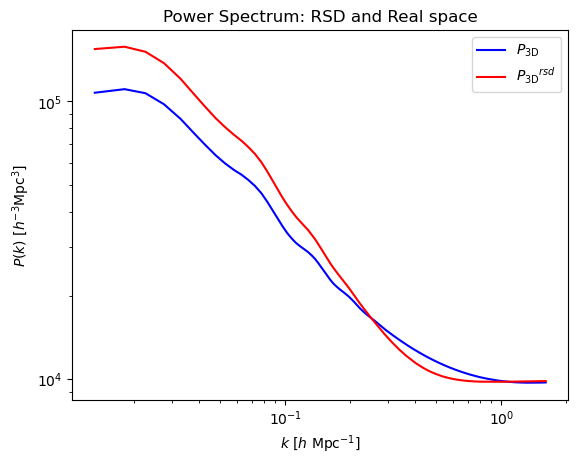

<Figure size 1500x1000 with 0 Axes>

In [112]:
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_mean, label=r"$P_\mathrm{3D}$", color="b")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_mean, label=r"${P_\mathrm{3D}}^{rsd}$", color="r")

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum: RSD and Real space")
#plt.xlim(0.06, 0.9)
plt.figure(figsize=(15, 10))
plt.savefig('Power_Spectrum_rsd_real_space.png', format='png');

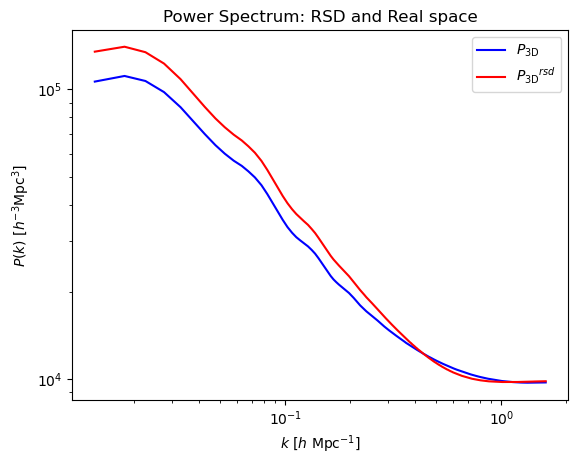

In [6]:
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_mean, label=r"$P_\mathrm{3D}$", color="b")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_mean, label=r"${P_\mathrm{3D}}^{rsd}$", color="r")

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum: RSD and Real space")
#plt.xlim(0.06, 0.9)
plt.savefig('Power_Spectrum_rsd_real_space.png', format='png')

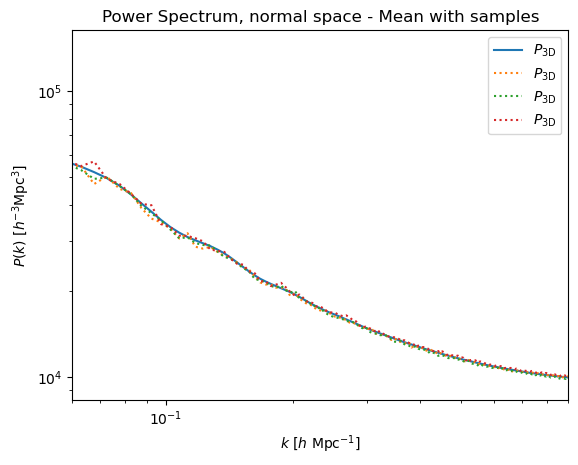

In [7]:
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_mean, label=r"$P_\mathrm{3D}$")
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_pk[0], label=r"$P_\mathrm{3D}$", linestyle="dotted")
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_pk[10], label=r"$P_\mathrm{3D}$", linestyle="dotted")
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_pk[100], label=r"$P_\mathrm{3D}$", linestyle="dotted")
# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum, normal space - Mean with samples")
plt.xlim(0.06, 0.9)
plt.savefig('Power_Spectrum_normal_with_sample.png', format='png')

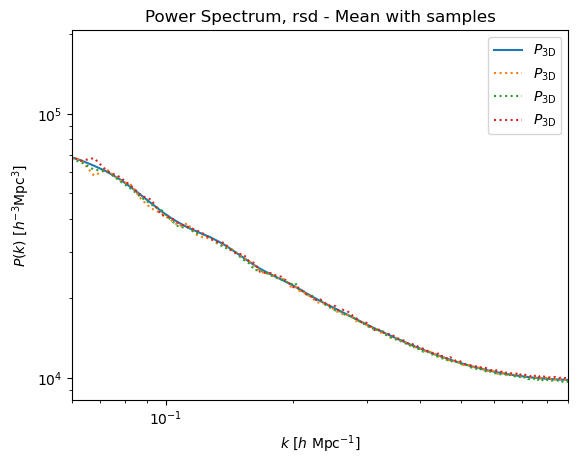

In [8]:
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_mean, label=r"$P_\mathrm{3D}$")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_pk[0], label=r"$P_\mathrm{3D}$", linestyle="dotted")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_pk[10], label=r"$P_\mathrm{3D}$", linestyle="dotted")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_pk[100], label=r"$P_\mathrm{3D}$", linestyle="dotted")
# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum, rsd - Mean with samples")
plt.xlim(0.06, 0.9)
plt.savefig('Power_Spectrum_rsd_with_sample.png', format='png')

### Correlation map

In [27]:
from run_nbk_funcs import cosmo_parser, PacMan, Hartlap, HubblePar, covariation_matrix, error_message
from nbodykit.lab import cosmology

In [28]:
def xy_distance(v, u):
    return np.sqrt((v-u)[0]**2 + (v-u)[1]**2)

def r_distance(s, p):
    return np.sqrt(s**2 + p**2)

def integrand_xi(Pk, k, r):
    return k * Pk * np.sin(k*r) / r

def corr_func(r, Pk, k_array):
    integral = 0
    for i in range(len(Pk)-1):
        integral += (integrand_xi(Pk=Pk[i+1], k=k_array[i+1], r=r) - integrand_xi(r=r, Pk=Pk[i], k=k_array[i]) * (k_array[i+1]-k_array[i]) )/2
    return integral/(2*np.pi**2)

In [29]:
snapdir = "/media/fuffolo97/HDD1/UNI/Tesi/Halos/fiducial/10"
snapnum = 2
z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
redshift = z_dict[snapnum]

datas = FoF_catalog(snapdir, snapnum, read_IDs=False)

pos_h = (datas.GroupPos  / 1e3 ).astype(np.float32)                   # positions in Mpc/h
mass  = (datas.GroupMass * 1e10).astype(np.float32)                   # masses in M_sun/
vel   = (datas.GroupVel  * (1.0+redshift)).astype(np.float32)         # Halo peculiar velocities in km/s

H_cosmo = HubblePar(z = redshift, O_m = fiducial_vals["Om"], H_0 = fiducial_vals["h"], w = fiducial_vals["w"])
print(H_cosmo)
assert H_cosmo > 0
pos_rsd = []
for i in range(len(vel)):
    pos_rsd.append(PacMan(pos_h[i] + (1+redshift) * np.array( ([0, 0, vel[i][2]/ H_cosmo ]) ) ))
pos_rsd = np.array(pos_rsd, dtype=np.float32) 

77.7723541517164


In [30]:
# import redshift_space_library as RSL
# from copy import deepcopy

# pos_rsd_RSL = deepcopy(pos_h)
# RSL.pos_redshift_space(pos_rsd_RSL, vel, 1000., H_cosmo, redshift, axis=2)

# a = pos_rsd_RSL - pos_rsd
# for i in range(len(a)):
#     if not (a[i] == [0., 0., 0.]).all: print(a)

In [31]:
BoxDim = 1000
dtype_cust = [("Position", (np.float32, 3)), ("RSDPosition", (np.float32, 3)), ("Velocity", (np.float32, 3)), ("Mass", np.float32)]
N_mesh = 512

with open('./data_source_elsb.dat', "wb") as ff:
    pos_h.tofile(ff); pos_rsd.tofile(ff); vel.tofile(ff); mass.tofile(ff)
    ff.seek(0)

# create nbodykit BinaryCatalog
binCat = BinaryCatalog(ff.name, dtype_cust)

# create mesh
mesh = binCat.to_mesh(resampler='tsc', Nmesh=N_mesh,
                        position='Position', weight="Mass",
                        compensated=True,  # deconvolving
                        interlaced=True,   # antialiasing
                        BoxSize=BoxDim
                        )
mesh_rsd = binCat.to_mesh(resampler='tsc', Nmesh=N_mesh,
                          compensated=True,  # deconvolving
                          interlaced=True,   # antialiasing
                          position='RSDPosition', weight="Mass",
                          BoxSize=BoxDim
                        )

In [32]:
r = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)
r_rsd = FFTPower(mesh_rsd, mode='1d', dk=0.005, kmin=0.01)

Pk = r.power["power"].real
Pk_rsd = r_rsd.power["power"].real
k = r.power["k"]

In [87]:
m_pols = FFTPower(mesh, Nmesh=N_mesh, BoxSize=1000., mode='2d', dk=0.005, poles=[2])

In [88]:
for i in m_pols.power.attrs:
    print("%s = %s" %(i, str(m_pols.power.attrs[i])))

Nmesh = [512 512 512]
BoxSize = [1000. 1000. 1000.]
Lx = 1000.0
Ly = 1000.0
Lz = 1000.0
volume = 1000000000.0
mode = 2d
los = [0, 0, 1]
Nmu = 5
poles = [2]
dk = 0.005
kmin = 0.0
kmax = None
N1 = 195602
N2 = 195602
shotnoise = 9879.198710022543


In [96]:
quadrupole = m_pols.power
k = quadrupole['k']
power = quadrupole['power'].real

KeyError: '`power_2` is not a valid variable name'

In [93]:
power_2 = m_pols.poles["power_2"].real

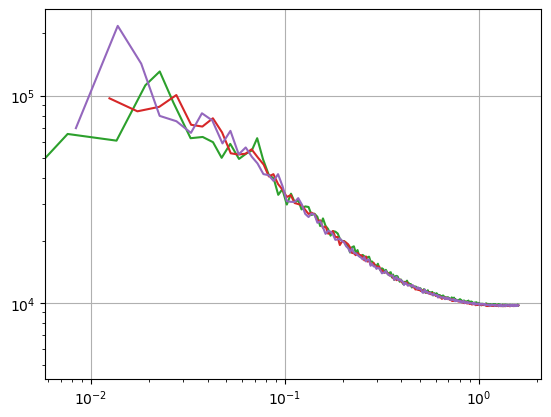

In [95]:
plt.loglog(k, power)
plt.grid();

In [ ]:
np.shape(Pl)

(16, 5)

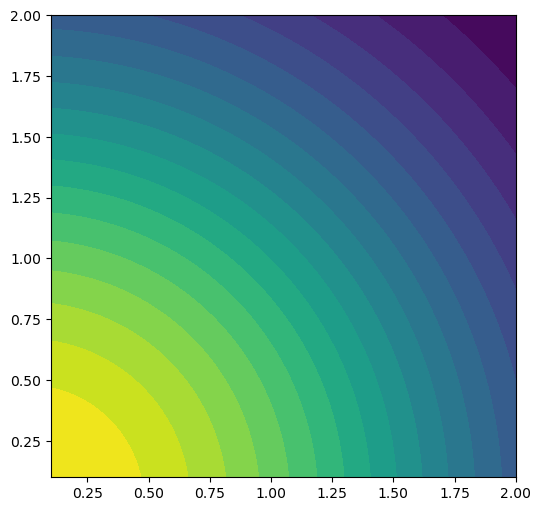

In [17]:
# make data
X, Y = np.meshgrid(np.linspace(0.1, 2, 1000), np.linspace(0.1, 2, 1000))
xi = (np.array(corr_func(r=r_distance(X,Y), Pk=Pk, k_array=k)))
levels = np.linspace(xi.min(), xi.max(), 20)

# plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(X, Y, xi, levels=levels);
#ax.legend([ax.contourf.collections[0]], ['Correlation Level'], loc='upper right');

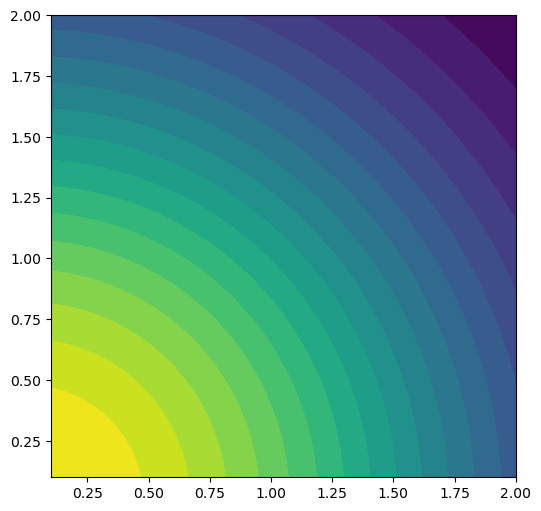

In [19]:
xi_rsd = np.array(corr_func(r=r_distance(X,Y), Pk=Pk_rsd, k_array=k))
levels_rsd = np.linspace(xi_rsd.min(), xi_rsd.max(), 20)

# plot
# plt.legend()
fig_rsd, ax_rsd = plt.subplots(figsize=(6,6))
ax_rsd.contourf(X, Y, xi_rsd, levels=levels_rsd);

<Figure size 1000x600 with 0 Axes>

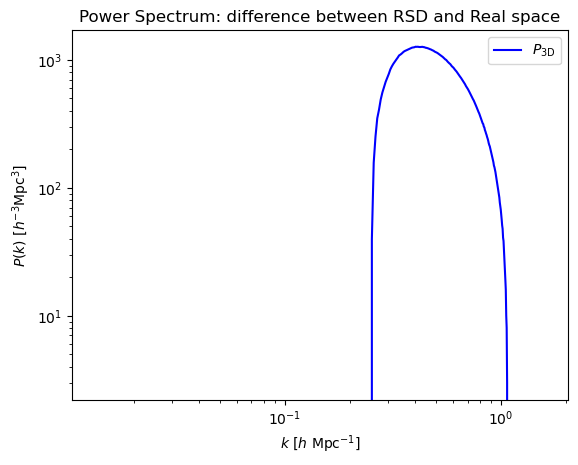

<Figure size 1000x600 with 0 Axes>

In [16]:
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_mean - fiducial_rsd_pk_mean, label=r"$P_\mathrm{3D}$", color="b")
# plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_mean, label=r"${P_\mathrm{3D}}^{rsd}$", color="r")

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum: difference between RSD and Real space")
#plt.xlim(0.06, 0.9)
plt.figure(figsize=(10, 6))
#plt.savefig('Power_Spectrum_rsd_real_space.png', format='png')

### Power Spectrum and Wavelet Scatering Transfomr plots

In [17]:
cons_pk, cons_pk_no_W, cons_rsd_pk, cons_rsd_pk_no_W = [], [], [], []
with open("./ZZ_results/constrains_pk.res", "rb") as f:
    while True:
        try:
            cons_pk.append(pickle.load(f))
        except EOFError:
            break
with open("./ZZ_results/constrains_pk_no_W.res", "rb") as f:
    while True:
        try:
            cons_pk_no_W.append(pickle.load(f))
        except EOFError:
            break
with open("./ZZ_results/constrains_rsd_pk.res", "rb") as f:
    while True:
        try:
            cons_rsd_pk.append(pickle.load(f))
        except EOFError:
            break
with open("./ZZ_results/constrains_rsd_pk_no_W.res", "rb") as f:
    while True:
        try:
            cons_rsd_pk_no_W.append(pickle.load(f))
        except EOFError:
            break

In [18]:
cons_wst, cons_wst_no_W, cons_rsd_wst = [], [], []
with open("./ZZ_results/constrains_wst.res", "rb") as f:
    while True:
        try:
            cons_wst.append(pickle.load(f))
        except EOFError:
            break
with open("./ZZ_results/constrains_wst_no_W.res", "rb") as f:
    while True:
        try:
            cons_wst_no_W.append(pickle.load(f))
        except EOFError:
            break
with open("./ZZ_results/constrains_rsd_wst.res", "rb") as f:
    while True:
        try:
            cons_rsd_wst.append(pickle.load(f))
        except EOFError:
            break

In [19]:
mean_vals = np.array((0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1))
mean_vals_no_W = np.array((0.3175, 0.049, 0.6711, 0.9624, 0.834, 0))

In [20]:
Bins = 450
n_points = 1000000
x_Ob  = np.linspace(0.3125, 0.3225, n_points)
x_Om  = np.linspace(0.025,  0.075,  n_points)
x_h   = np.linspace(0,      1.25,   n_points)
x_ns  = np.linspace(0.47,   1.5,    n_points)
x_s8  = np.linspace(0.57,   1.07,   n_points)
x_Mnu = np.linspace(-0.6,   0.6,    n_points)

x_vecs = [x_Ob, x_Om, x_h, x_ns, x_s8, 0, x_Mnu]

In [21]:
data_wst_n  = np.random.multivariate_normal(mean=mean_vals, cov=cons_wst[0],     size=350000)
data_wst_rd = np.random.multivariate_normal(mean=mean_vals, cov=cons_rsd_wst[0], size=350000)
data_pk_n   = np.random.multivariate_normal(mean=mean_vals, cov=cons_pk[0],      size=350000)
data_pk_rd  = np.random.multivariate_normal(mean=mean_vals, cov=cons_rsd_pk[0],  size=350000)

/tmp/ipykernel_328983/1602212984.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_wst_n  = np.random.multivariate_normal(mean=mean_vals, cov=cons_wst[0],     size=350000)
/tmp/ipykernel_328983/1602212984.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_wst_rd = np.random.multivariate_normal(mean=mean_vals, cov=cons_rsd_wst[0], size=350000)
/tmp/ipykernel_328983/1602212984.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_pk_n   = np.random.multivariate_normal(mean=mean_vals, cov=cons_pk[0],      size=350000)
/tmp/ipykernel_328983/1602212984.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_pk_rd  = np.random.multivariate_normal(mean=mean_vals, cov=cons_rsd_pk[0],  size=350000)


In [22]:
data_wst_n_no_W  = np.random.multivariate_normal(mean=mean_vals_no_W, cov=cons_wst_no_W[0], size=350000)
data_pk_n_no_W   = np.random.multivariate_normal(mean=mean_vals_no_W, cov=cons_pk_no_W[0],  size=350000)


/tmp/ipykernel_328983/251746889.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_wst_n_no_W  = np.random.multivariate_normal(mean=mean_vals_no_W, cov=cons_wst_no_W[0], size=350000)
/tmp/ipykernel_328983/251746889.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_pk_n_no_W   = np.random.multivariate_normal(mean=mean_vals_no_W, cov=cons_pk_no_W[0],  size=350000)


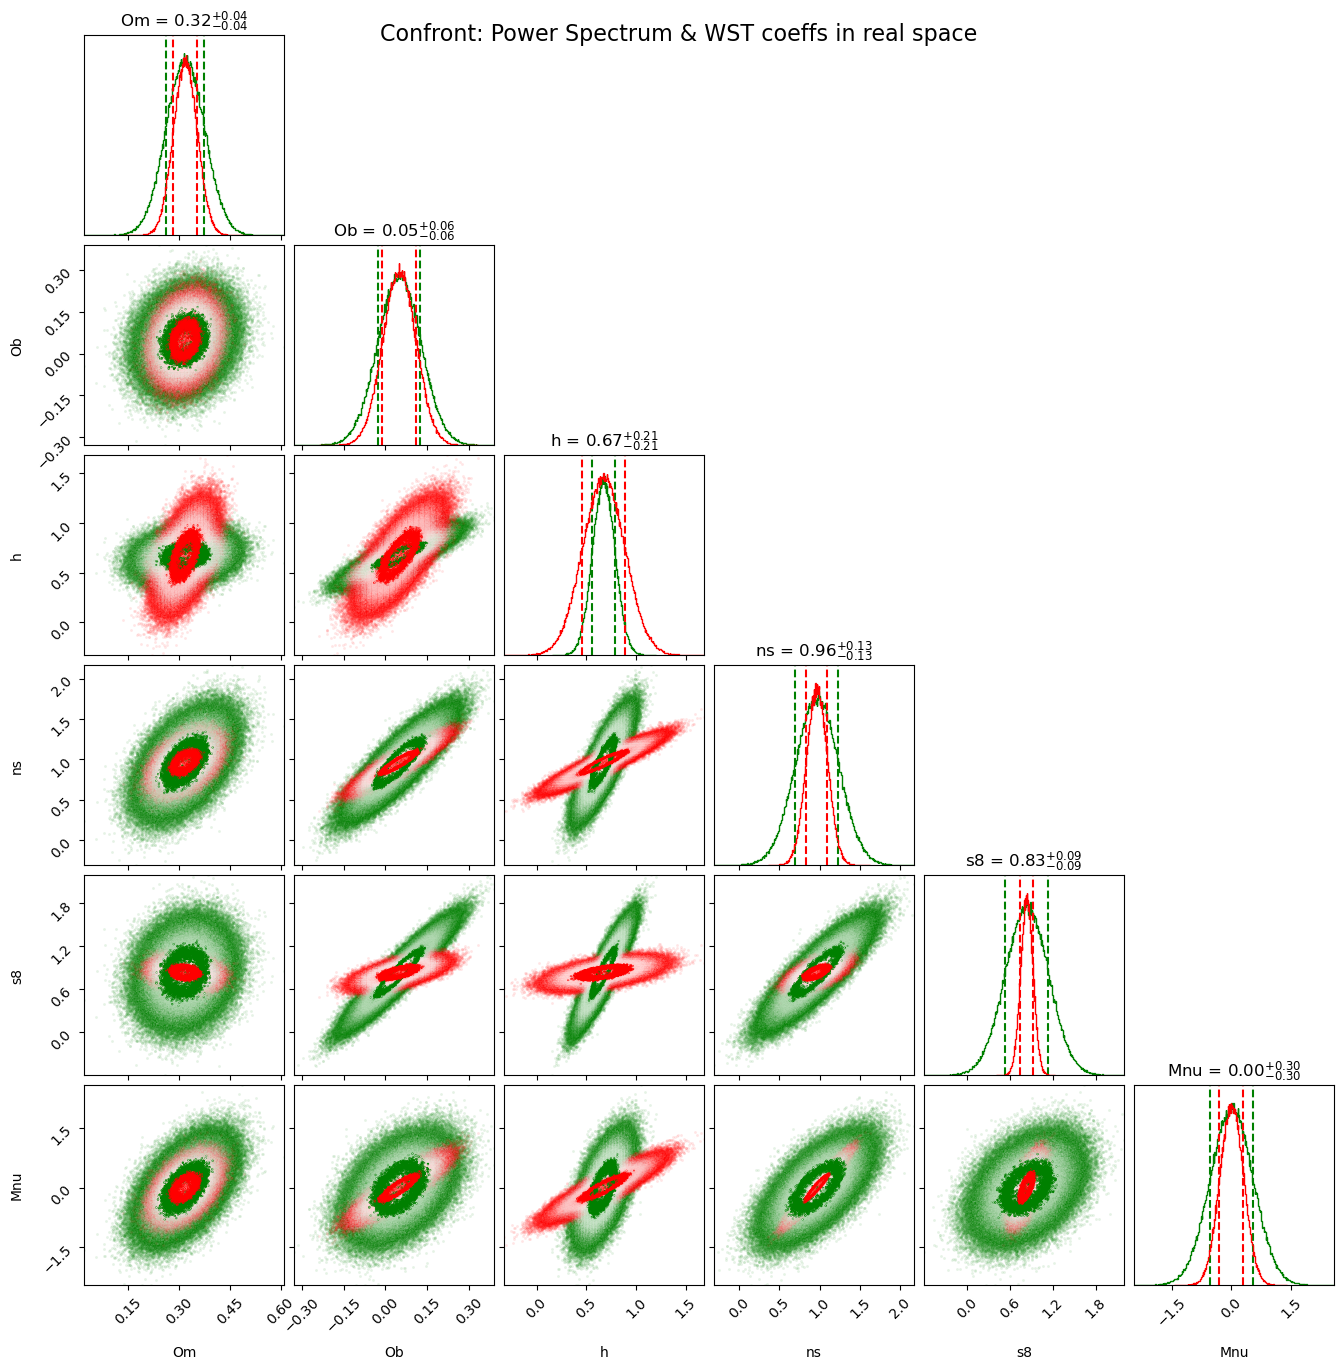

In [51]:
figure1_no_W = corner.corner(data_pk_n_no_W, labels=['Om', 'Ob', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"},
                        quantiles=(0.16, 0.84), levels=(1 - np.exp(-0.5),)
                        )
corner.corner(data_wst_n_no_W, labels=['Om', 'Ob', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                        quantiles=(0.16, 0.84), levels=(1 - np.exp(-0.5),),
                       fig=figure1_no_W)

figure1_no_W.suptitle('Confront: Power Spectrum & WST coeffs in real space', fontsize=16)
plt.savefig("PK_coeffs_N_RD_no_W.png")
plt.show();

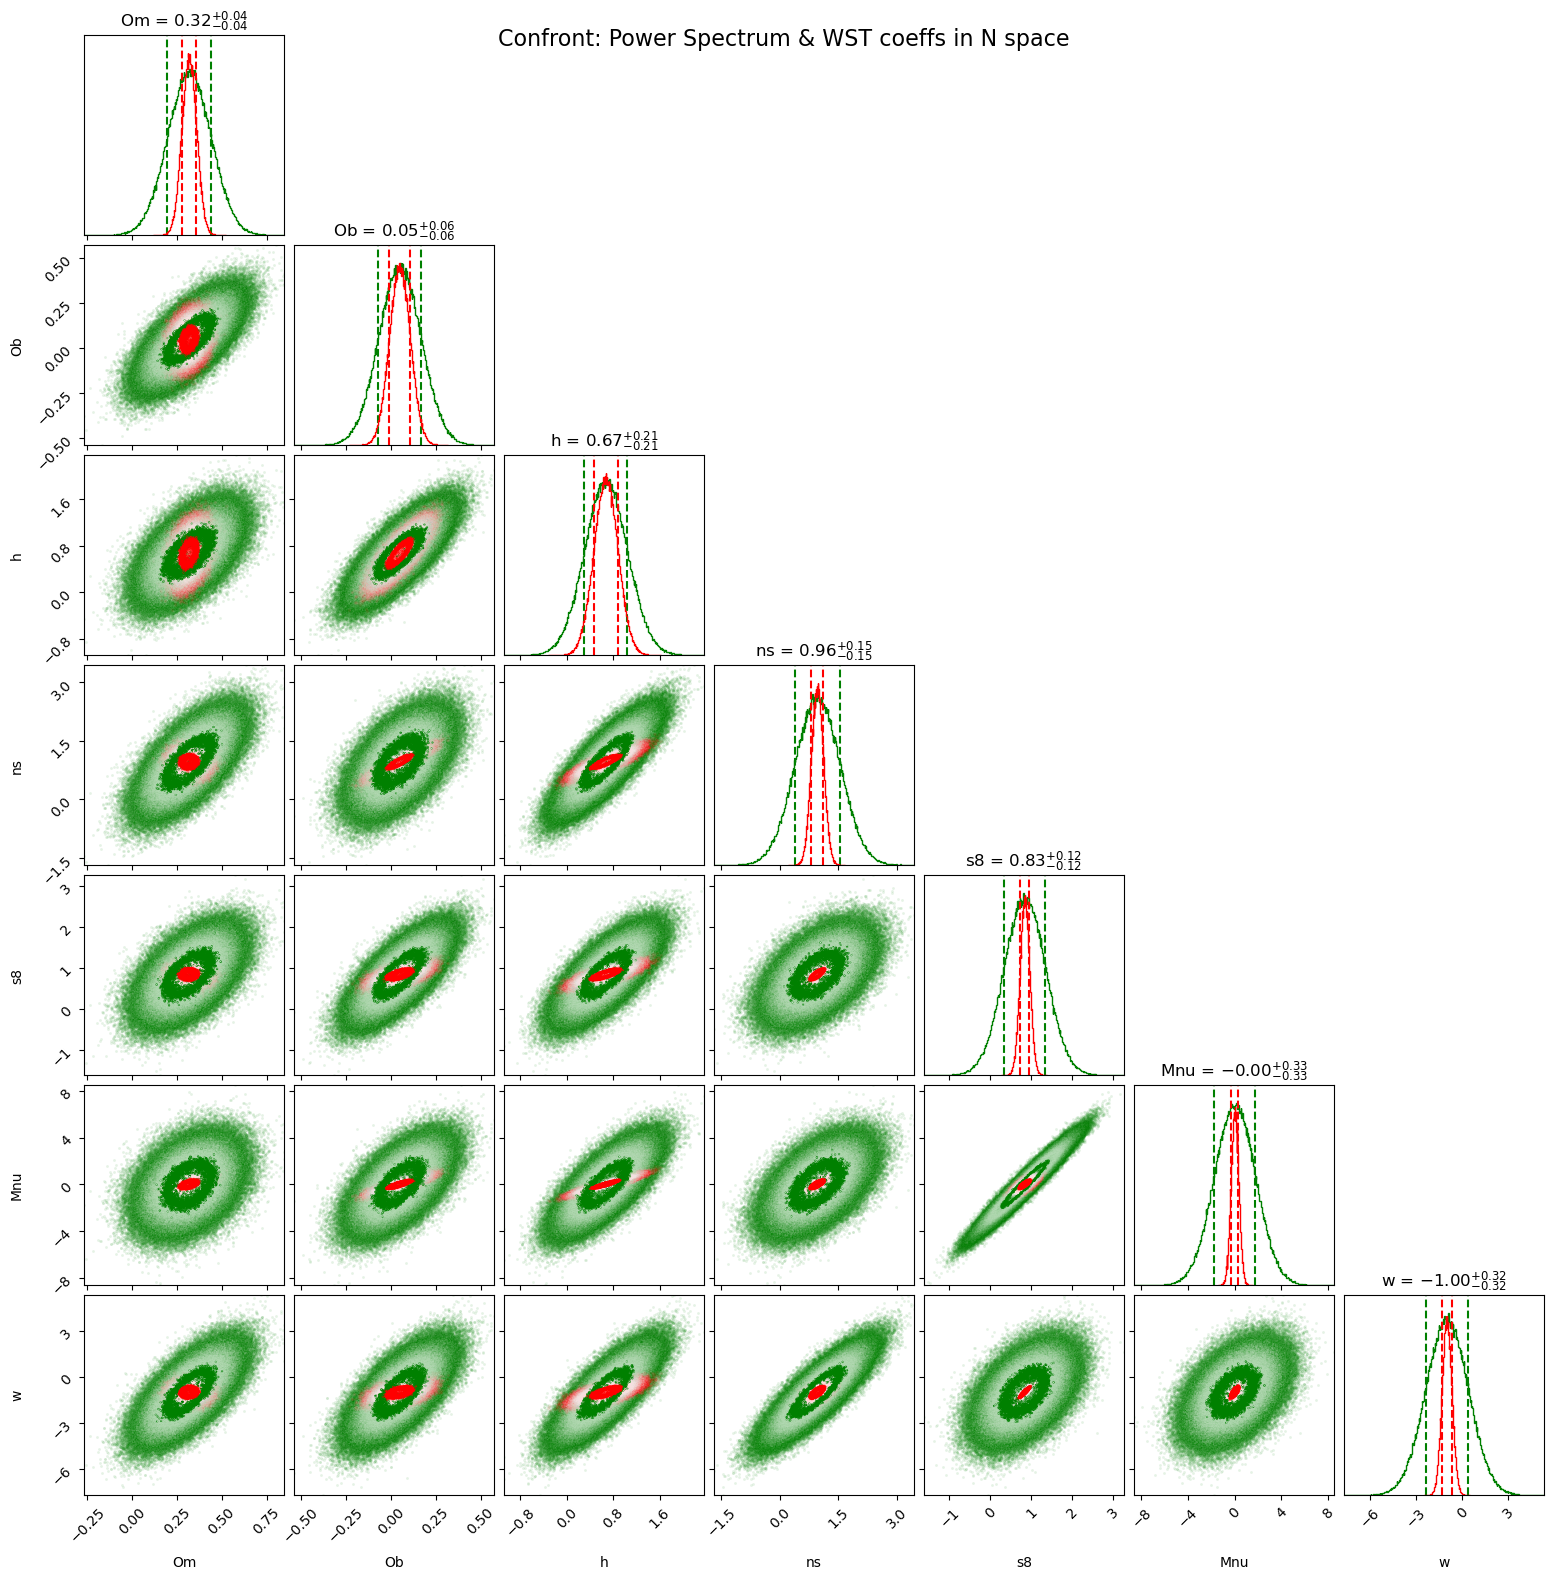

In [52]:
figure1 = corner.corner(data_pk_n, labels=['Om', 'Ob', 'h', 'ns','s8', 'Mnu','w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"},
                        quantiles=(0.16, 0.84), levels=(1 - np.exp(-0.5),)
                        )
corner.corner(data_wst_n, labels=['Om', 'Ob', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                        quantiles=(0.16, 0.84), levels=(1 - np.exp(-0.5),),
                       fig=figure1)

figure1.suptitle('Confront: Power Spectrum & WST coeffs in N space', fontsize=16)
plt.savefig("PK_coeffs_N_RD.png")
plt.show();

Text(0.5, 0.98, 'Power Spectrum real space - no w')

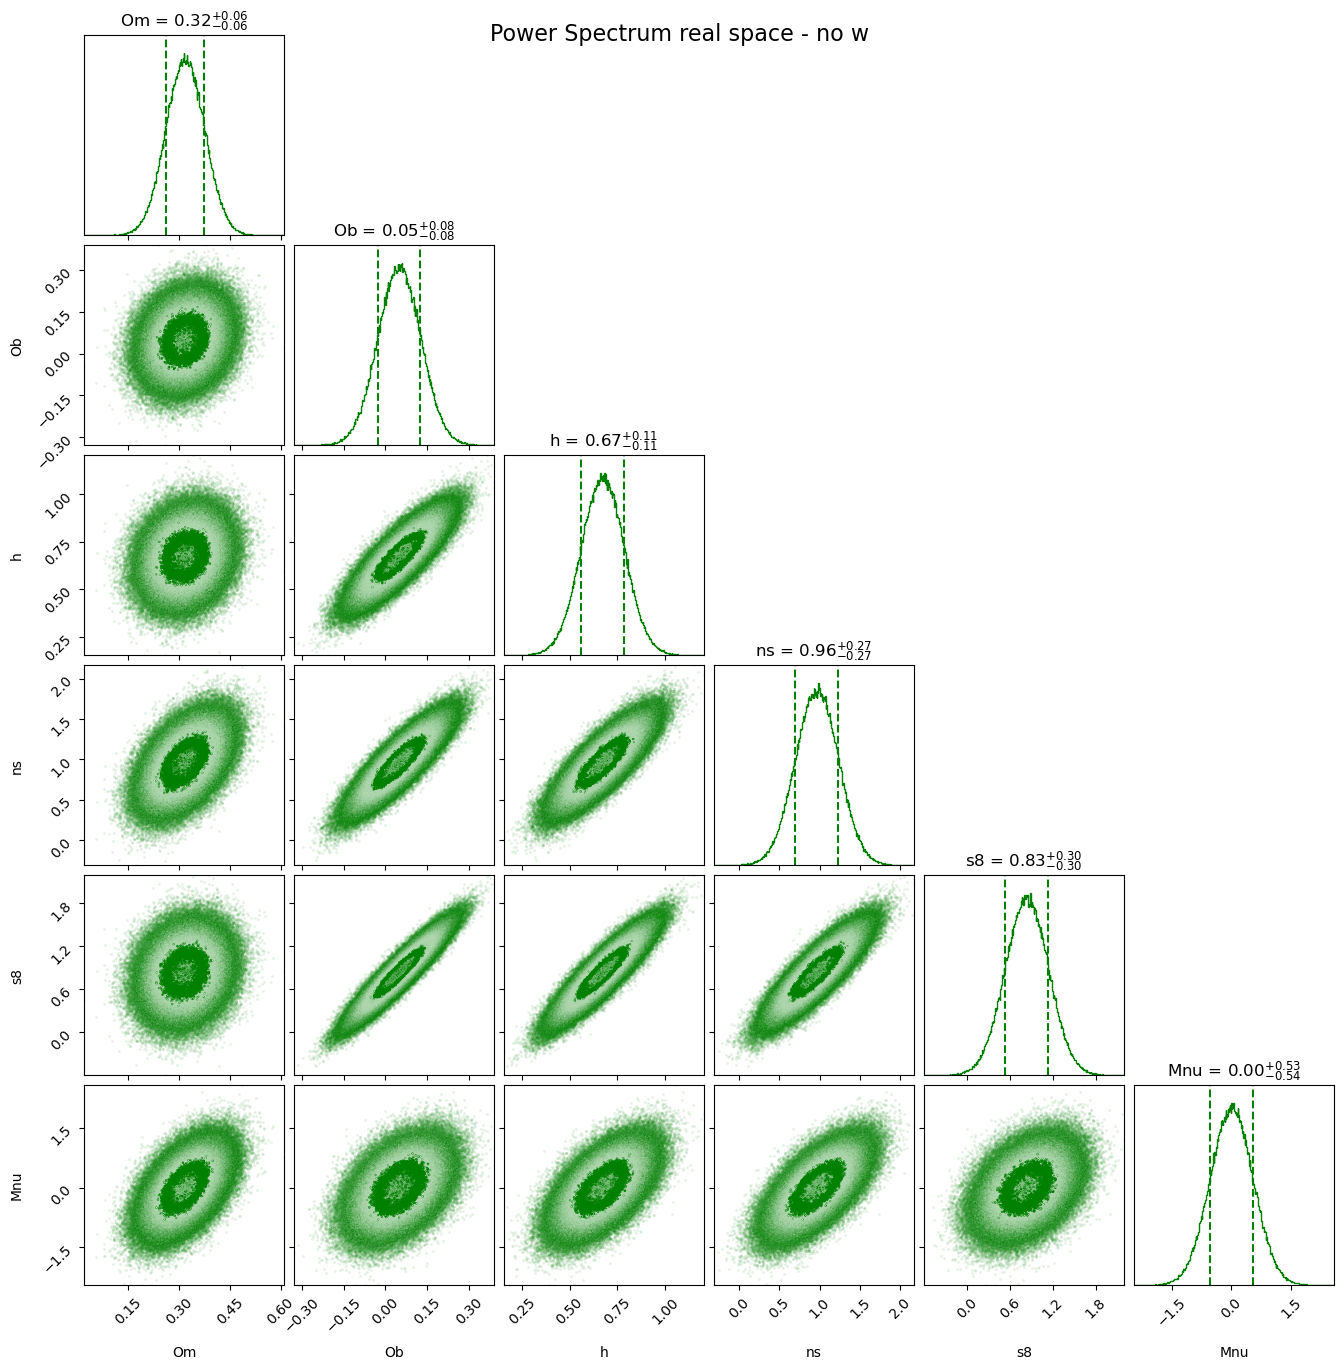

In [54]:
corner.corner(data_pk_n_no_W, labels=['Om', 'Ob', 'h', 'ns','s8', 'Mnu'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"},
                        quantiles=(0.16, 0.84), levels=(1 - np.exp(-0.5),)
                        )
plt.suptitle('Power Spectrum real space - no w', fontsize=16)

Text(0.5, 0.98, 'Power Spectrum real space')

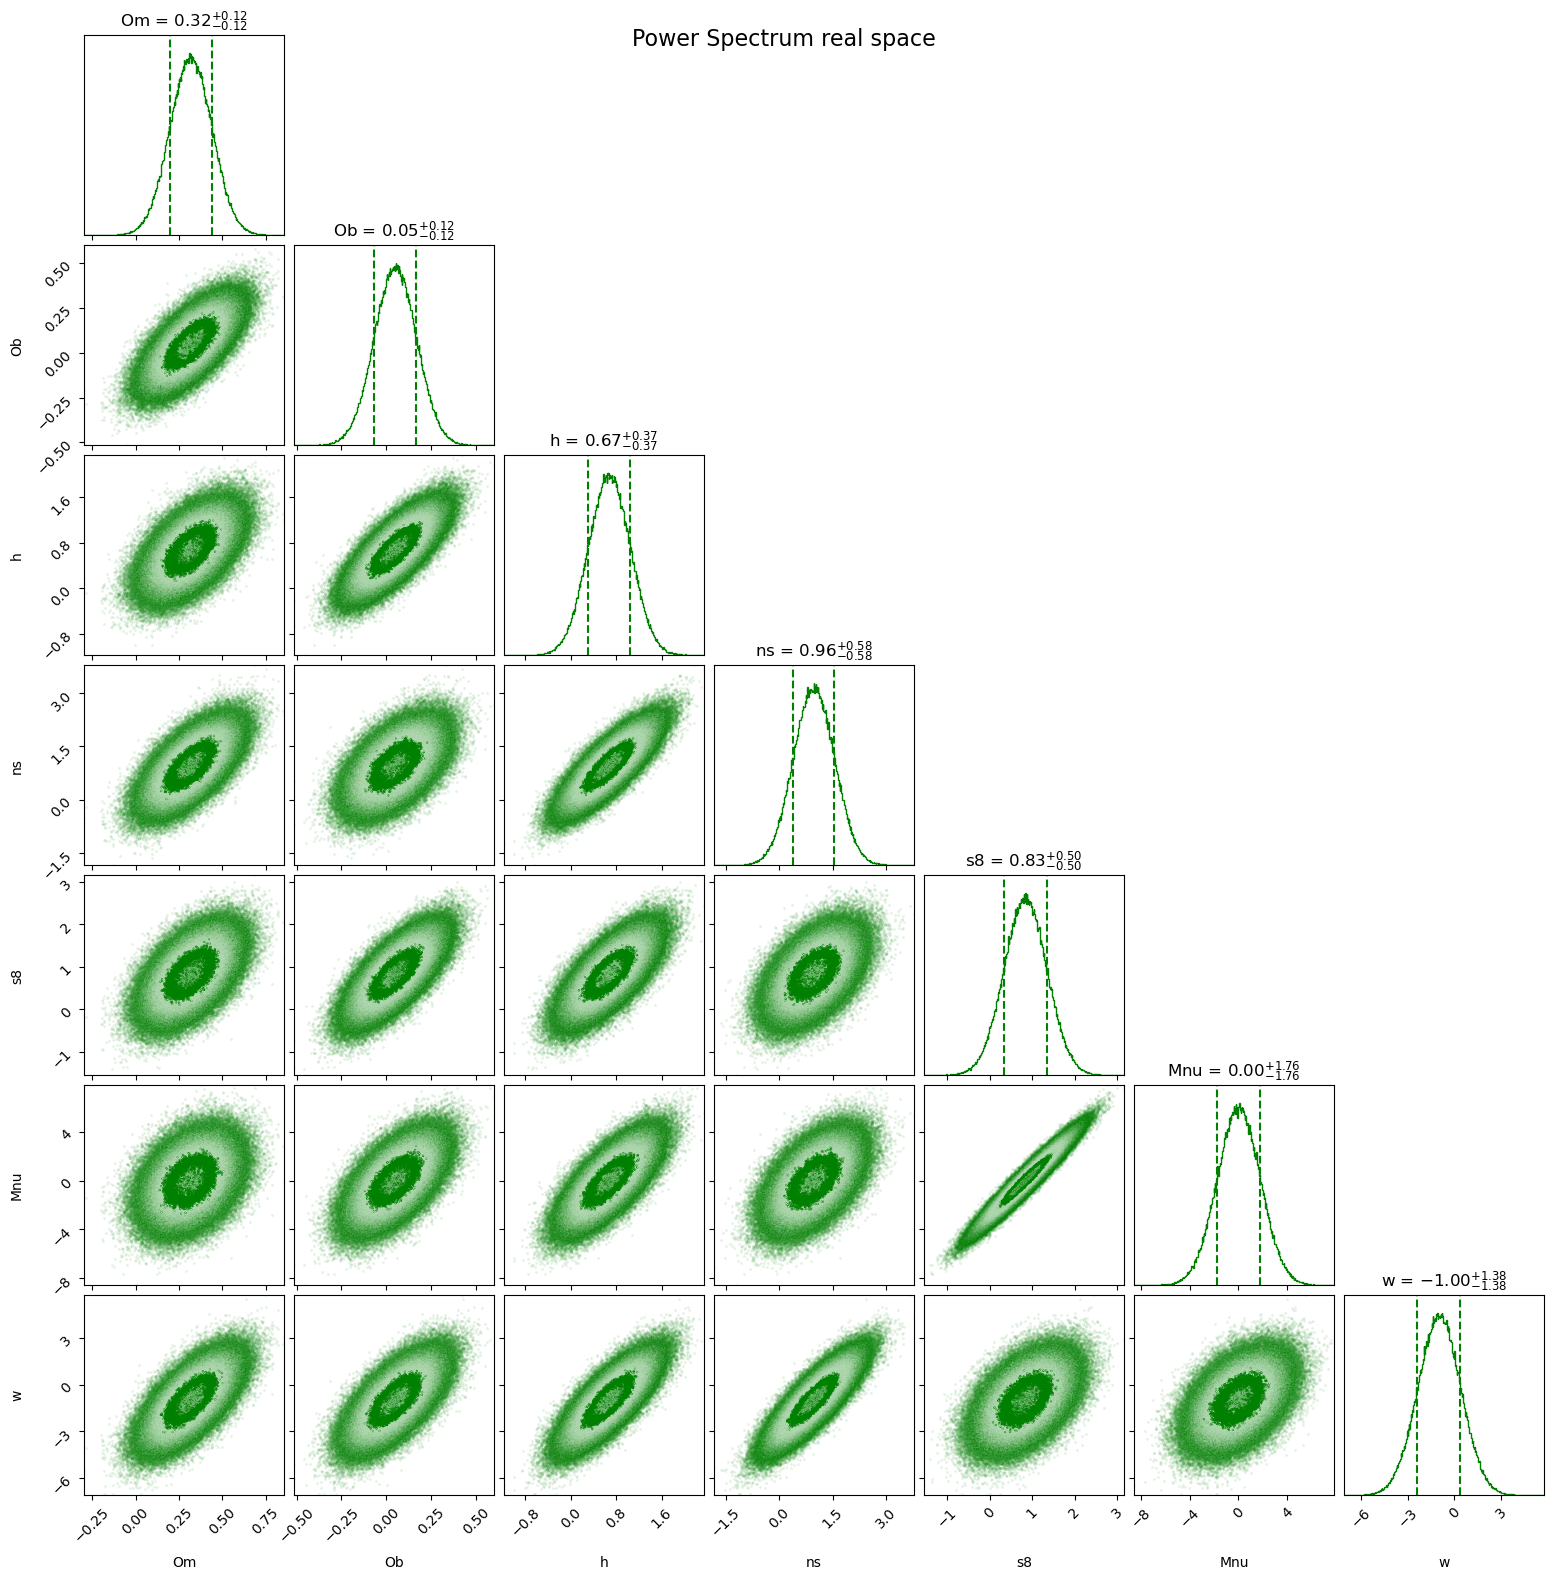

In [23]:
corner.corner(data_pk_n, labels=['Om', 'Ob', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"},
                        quantiles=(0.16, 0.84), levels=(1 - np.exp(-0.5),)
                        )
plt.suptitle('Power Spectrum real space', fontsize=16)

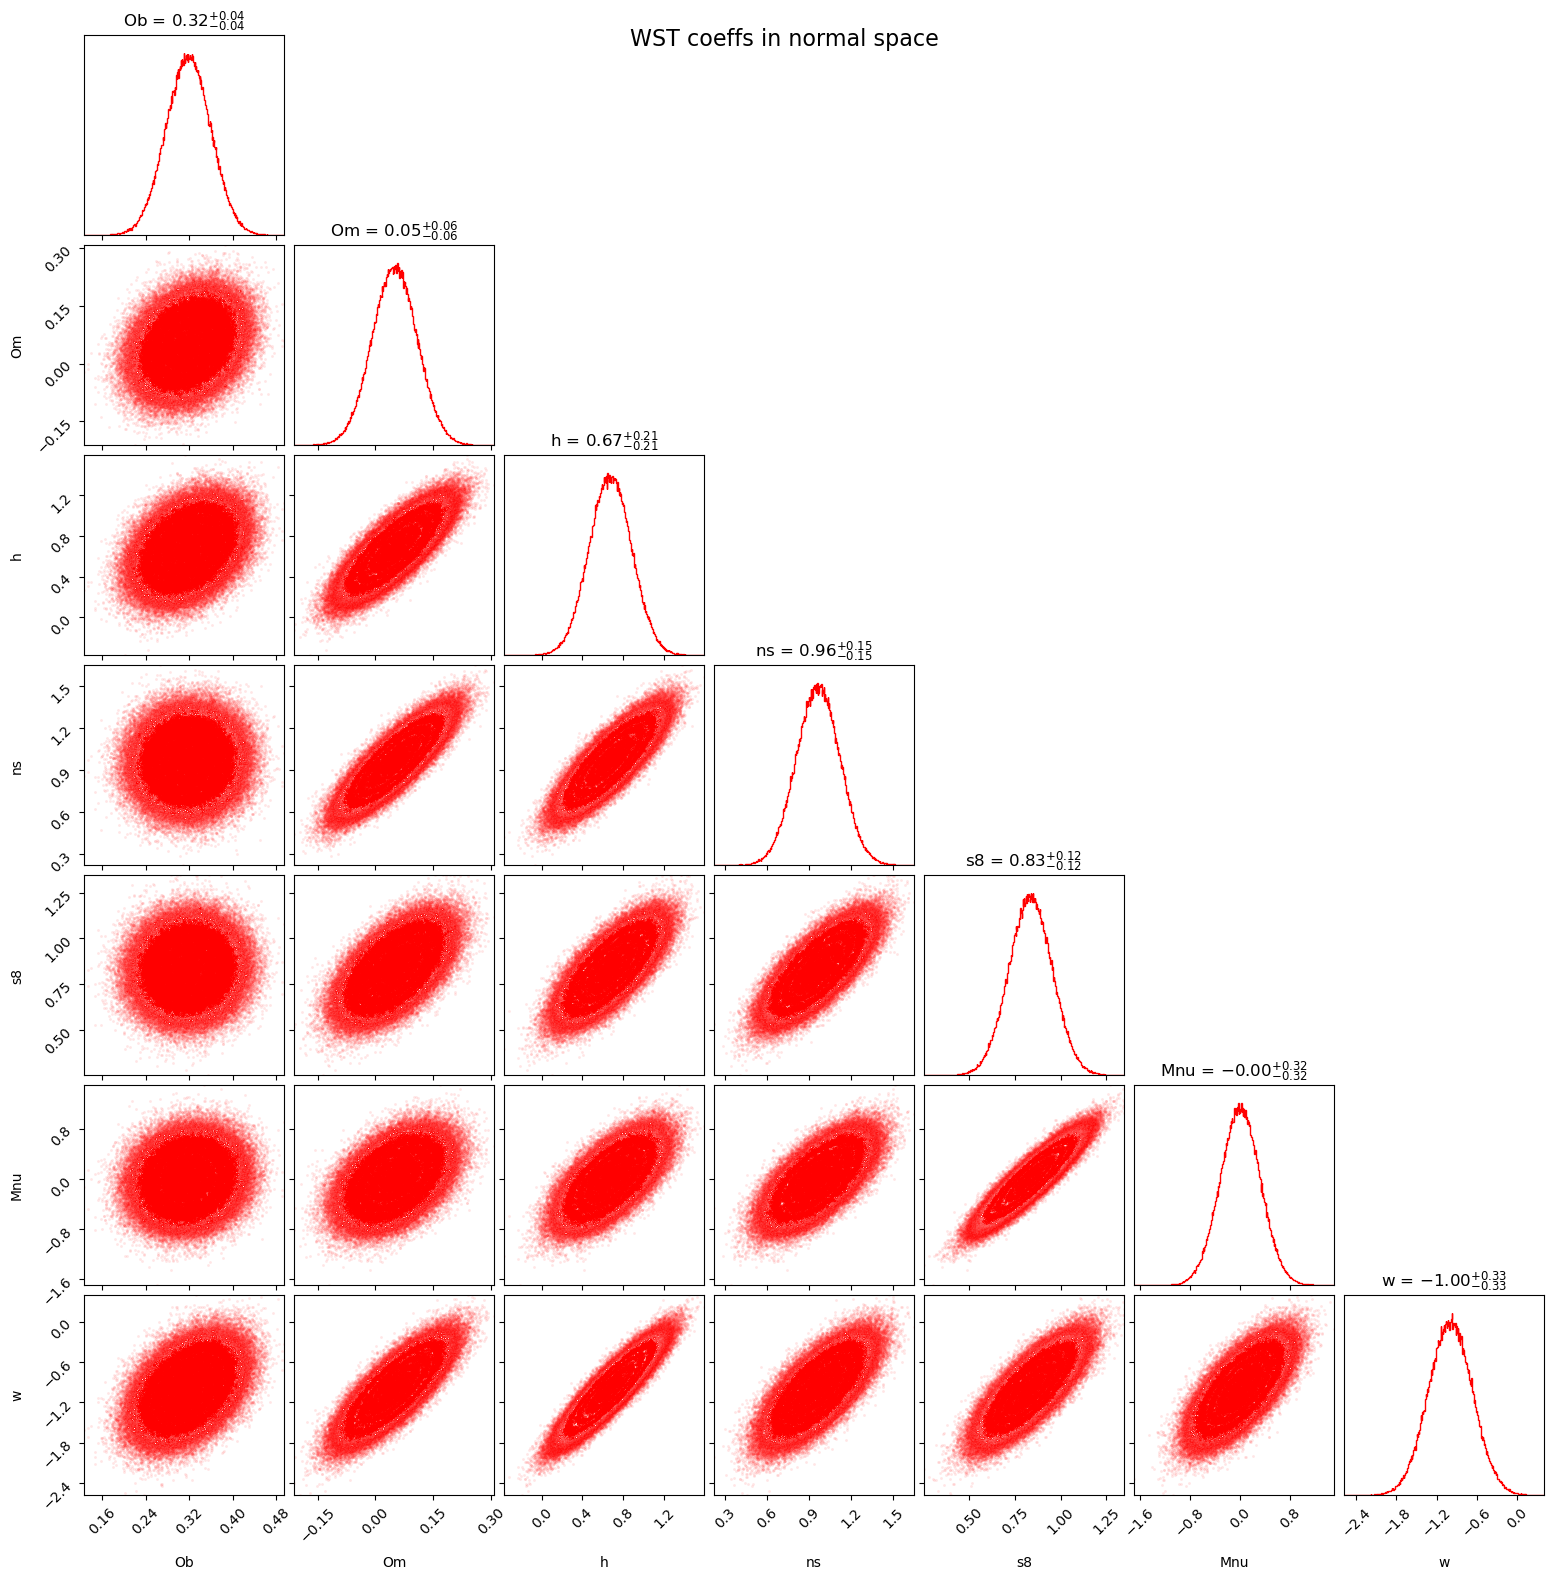

In [16]:
corner.corner(data_wst_n, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"}
                       )
plt.suptitle('WST coeffs in normal space', fontsize=16)
plt.show();

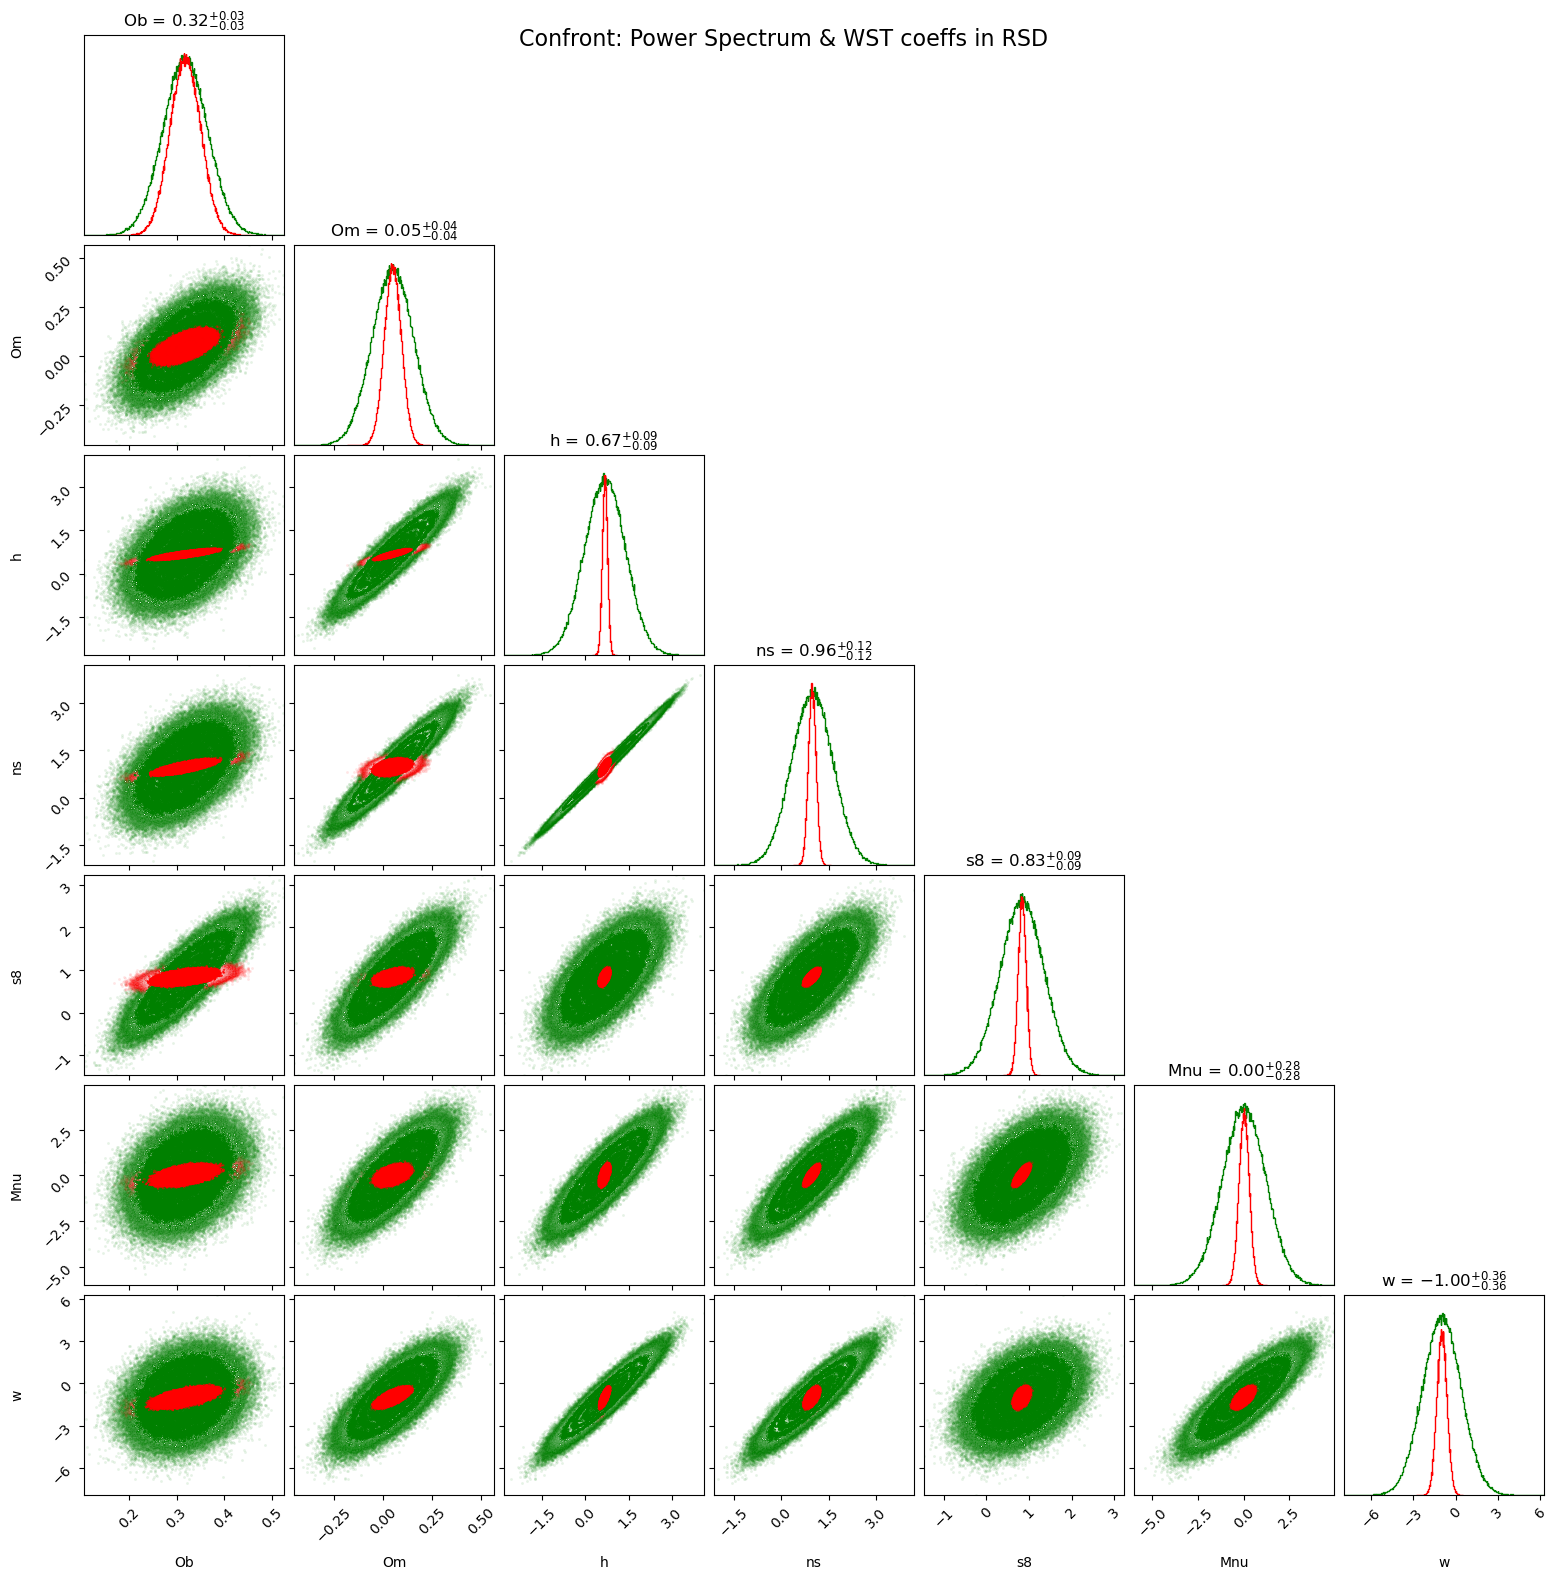

In [16]:
figure2 = corner.corner(data_pk_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu','w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"}
                       );
corner.corner(data_wst_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure2)

figure2.suptitle('Confront: Power Spectrum & WST coeffs in RSD', fontsize=16)
plt.savefig("PK-WST_coeffs_RSD.png")
plt.show();

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [18]:
s = np.zeros(4)

In [11]:
corner.corner(data_wst_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure2)

plt.suptitle('WST coeffs in RSD', fontsize=16)
plt.savefig("WST_coeffs_RSD.png")
plt.show();

NameError: name 'figure2' is not defined

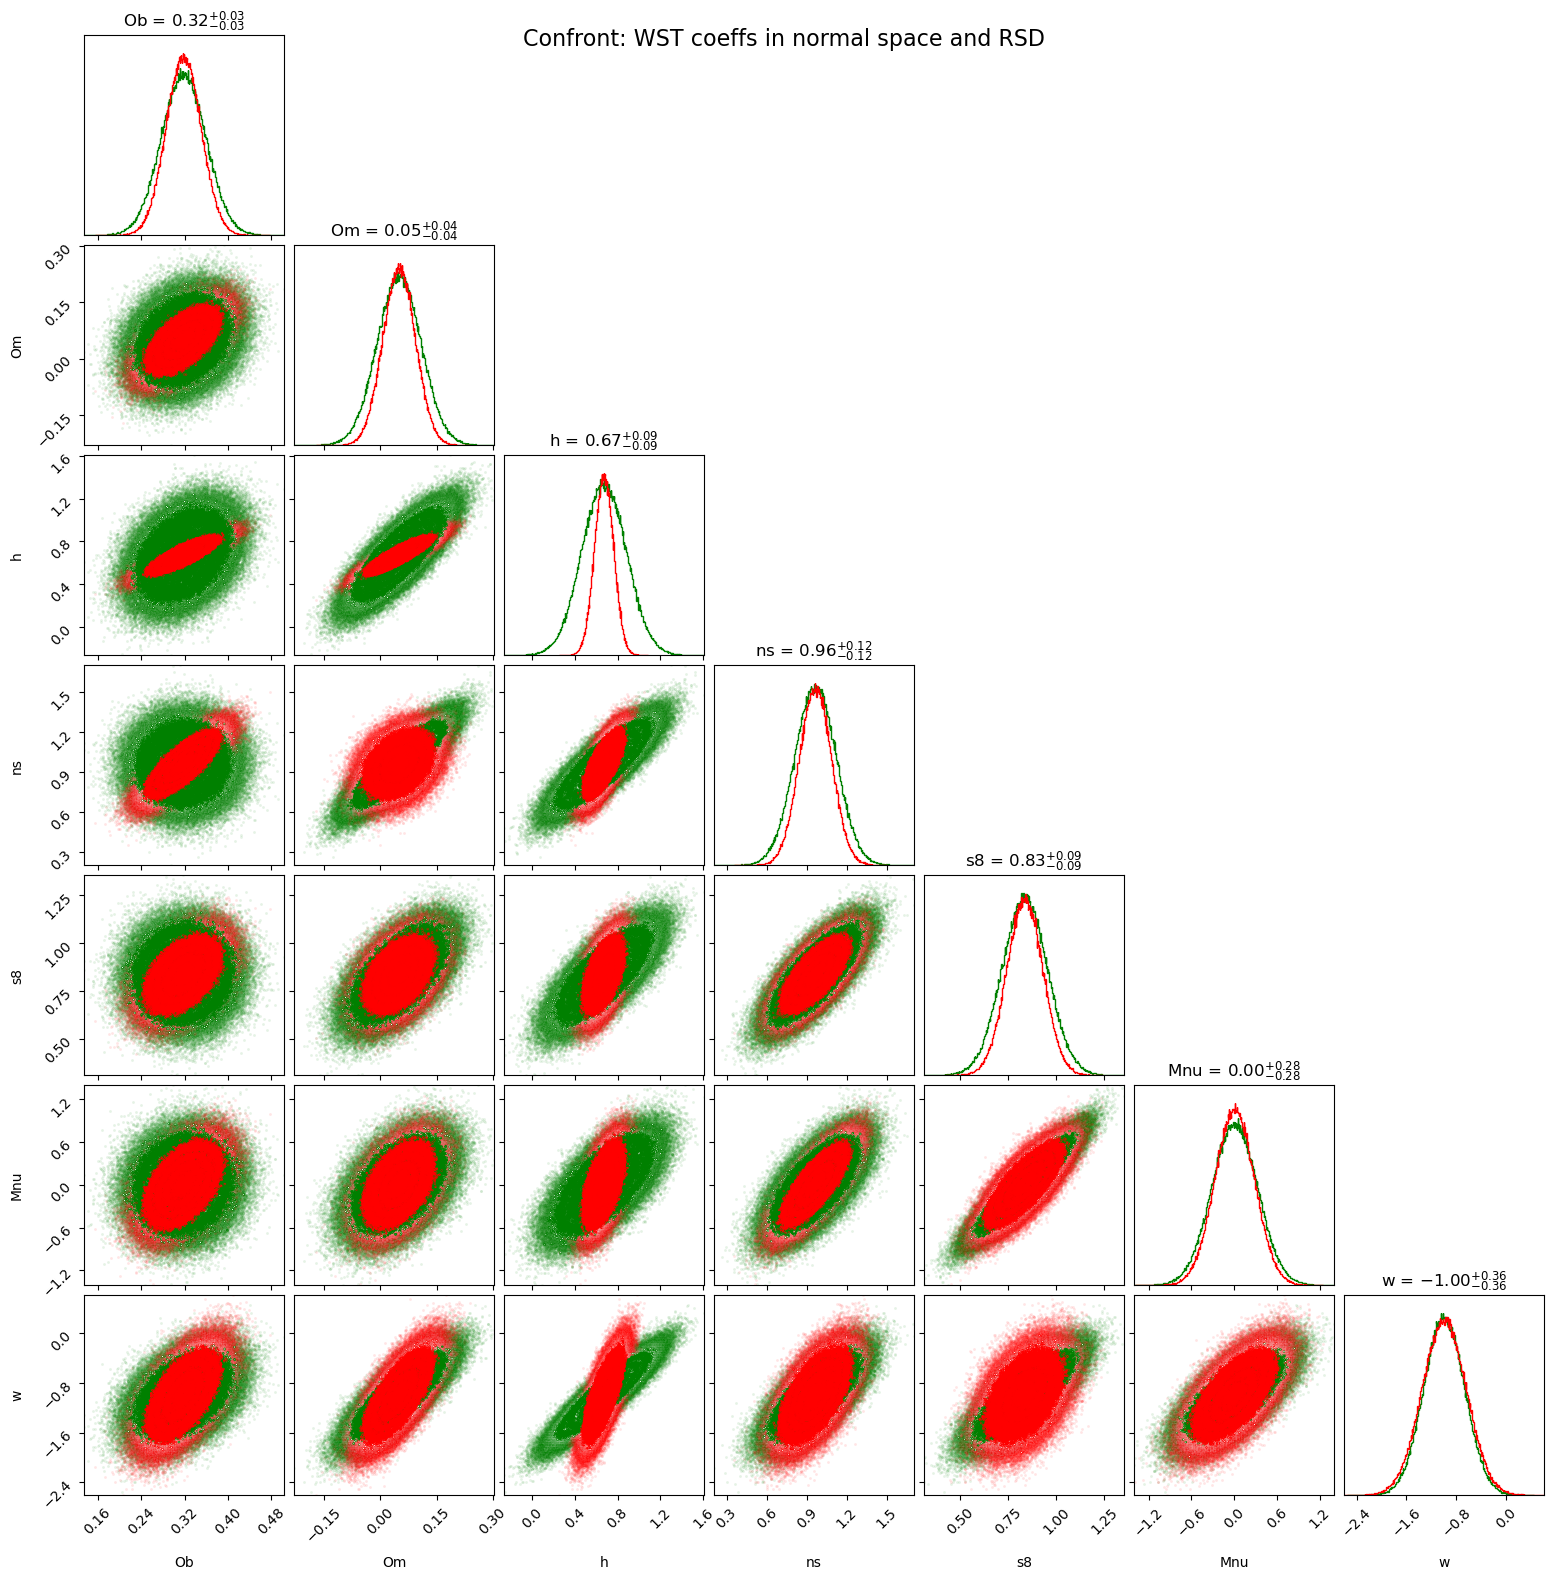

In [12]:
figure3 = corner.corner(data_wst_n, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu','w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"}
                       );
corner.corner(data_wst_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure3)

figure3.suptitle('Confront: WST coeffs in normal space and RSD', fontsize=16)
plt.savefig("WST_coeffs_N-RSD.png")
plt.show();

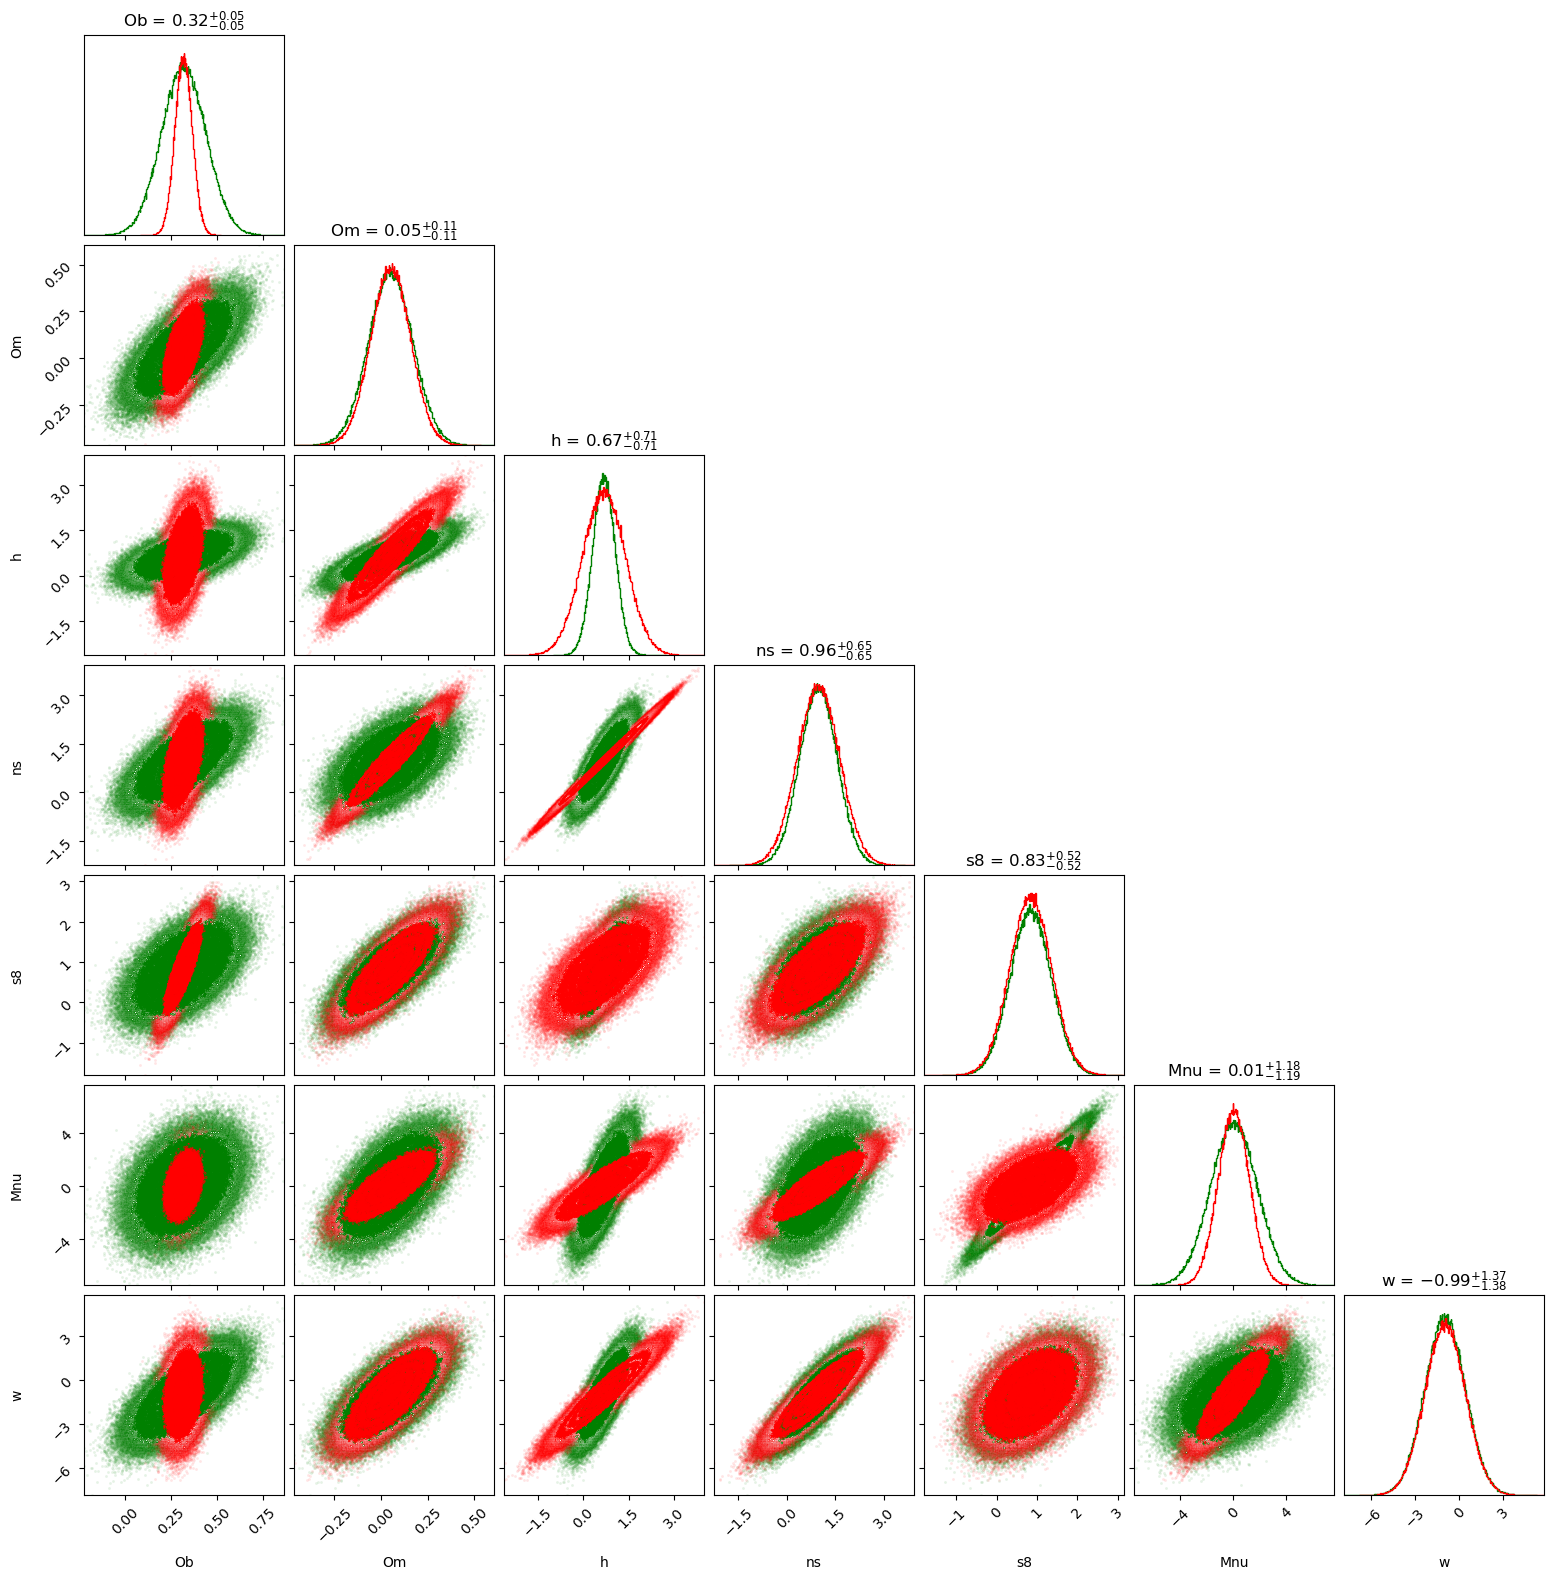

In [13]:
figure4 = corner.corner(data_pk_n, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu','w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"}
                       );
corner.corner(data_pk_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure4)

figure3.suptitle('Confront: PK coeffs in normal space and RSD', fontsize=16)
plt.savefig("PK_coeffs_N-RSD.png")
plt.show();

In [ ]:
break

## Grafico separazione parallela-perpendicolare

In [28]:
from run_nbk_funcs import cosmo_parser, PacMan, Hartlap, HubblePar, covariation_matrix, error_message

In [68]:
def xy_distance(v, u):
    return np.sqrt((v-u)[0]**2 + (v-u)[1]**2)

def r_distance(s, p):
    return np.sqrt(s**2 + p**2)

In [32]:
snapdir = "/media/fuffolo97/HDD1/UNI/Tesi/Halos/fiducial/10"
snapnum = 2
z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
redshift = z_dict[snapnum]

datas = FoF_catalog(snapdir, snapnum, read_IDs=False)

pos_h = (datas.GroupPos  / 1e3 ).astype(np.float32)                   # positions in Mpc/h
mass  = (datas.GroupMass * 1e10).astype(np.float32)                   # masses in M_sun/
vel   = (datas.GroupVel  * (1.0+redshift)).astype(np.float32)         # Halo peculiar velocities in km/s

H_cosmo = HubblePar(z = redshift, O_m = fiducial_vals["Om"], H_0 = fiducial_vals["h"], w = fiducial_vals["w"])
print(H_cosmo)
assert H_cosmo > 0
pos_rsd = []
for i in range(len(vel)):
    pos_rsd.append(PacMan(pos_h[i] + (1+redshift) * np.array( ([0, 0, vel[i][2]/ H_cosmo ]) ) ))
pos_rsd = np.array(pos_rsd, dtype=np.float32)                         # positions in RSD in Mpc/h
s, p = [], []
s_rsd, p_rsd = [], []
# for i in tqdm(range(len(pos_h))):
#     if i >= 10000: continue
#     for j in list(range(i+1, len(pos_h))):
#         if j > i:
#             s.append(xy_distance(pos_h[i], pos_h[j]))
#             p.append(pos_h[i][2] - pos_h[j][2])

i = 0
while i < 500:
    for j in list(range(i+1, len(pos_h))):
        if j > i:
            s.append(xy_distance(pos_h[i], pos_h[j]))
            p.append(pos_h[i][2] - pos_h[j][2])
            s_rsd.append(xy_distance(pos_rsd[i], pos_rsd[j]))
            p_rsd.append(pos_rsd[i][2] - pos_rsd[j][2])
    i += 1

1.0   0.049   67.11   0.951   0.951
77.7723541517164


In [38]:
from nbodykit.lab import cosmology

# define a cosmology obj for current cosmology folder
cosmology_obj = cosmology.Cosmology(h = fiducial_vals["h"],
                                    sigma8 = fiducial_vals["s8"],
                                    Omega0_cdm = fiducial_vals["Om"],
                                    n_s = fiducial_vals["ns"]
                                    )

In [62]:
def corr_func(r, Pk, k_array):
    integral = 0
    for i in range(len(Pk)):
        integral += k_array[i] * Pk[i] * np.sin(k_array[i]*r)/r
    return integral/(2*np.pi**2)

In [39]:
BoxDim = 1000
dtype_cust = [("Position", (np.float32, 3)), ("RSDPosition", (np.float32, 3)), ("Velocity", (np.float32, 3)), ("Mass", np.float32)]
N_mesh = 512

with open('./data_source_elsb.dat', "wb") as ff:
    pos_h.tofile(ff); pos_rsd.tofile(ff); vel.tofile(ff); mass.tofile(ff)
    ff.seek(0)

# create nbodykit BinaryCatalog
binCat = BinaryCatalog(ff.name, dtype_cust)

# create mesh
mesh = binCat.to_mesh(resampler='cic', Nmesh=N_mesh, compensated=True,
                        position='Position', weight="Mass",
                        # compensated = True, # antialiasing
                        BoxSize=BoxDim
                        )
mesh_rsd = binCat.to_mesh(resampler='cic', Nmesh=N_mesh, compensated=True,
                            position='RSDPosition', weight="Mass",
                            # compensated = True, # antialiasing
                            BoxSize=BoxDim
                            )


r = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)
r_rsd = FFTPower(mesh_rsd, mode='1d', dk=0.005, kmin=0.01)

Pk = r.power["power"].real
Pk_rsd = r_rsd.power["power"].real
k = r.power["k"]
k_rsd = r_rsd.power["k"]

In [66]:
Pk = r.power["power"].real
Pk_rsd = r_rsd.power["power"].real
k = r.power["k"]
k_rsd = r_rsd.power["k"]

In [67]:
corr_func(r = 10, Pk = Pk, k_array = k)

1729.4129213157155

In [79]:
xi = []

for i in range(len(k)):
    xi.append(corr_func(r = r_distance(s[i], p[i]), Pk = Pk, k_array = k))

In [86]:
np.shape(xi)

(320,)

In [92]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.array((s[0:320], p[0:320], xi )).reshape(320, 3) , columns=["s", "p", "xi"])

# df = sns.load_dataset('iris')
 
# set seaborn style
sns.set_style("white")

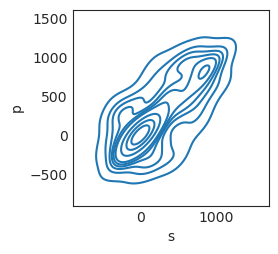

In [95]:
sns.kdeplot(x=df["s"], y=df["p"]);

In [46]:
# cf = cosmology.CorrelationFunction(r)
# cf_rsd = cosmology.CorrelationFunction(r_rsd)

In [47]:
plt.style.use('_mpl-gallery-nogrid')

In [59]:
levels = np.linspace(np.min(r.power["power"].real), np.max(r.power["power"].real), 7)
levels_rsd = np.linspace(np.min(r_rsd.power["power"].real), np.max(r_rsd.power["power"].real), 7)

TypeError: Invalid shape (320,) for image data

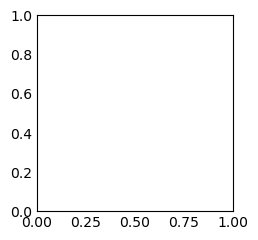

In [61]:
fig, ax = plt.subplots()
ax.imshow(r.power["power"].real);

In [22]:
len(p)

195101500

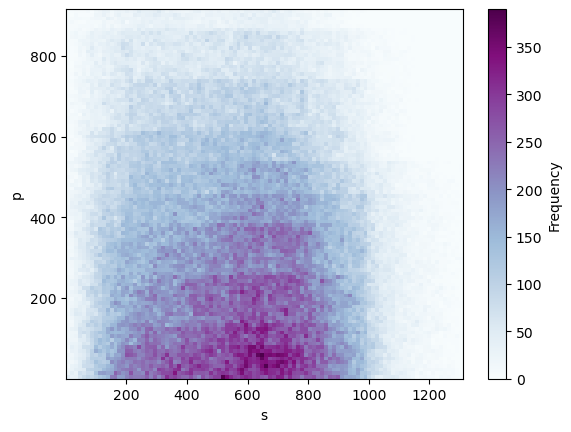

In [23]:
plt.hist2d(np.abs(s)[i for i in s if i % 10 == 0], np.abs(p)[i for i in p if i % 2 == 0], bins=(100, 100), cmap=plt.cm.BuPu)
plt.xlabel('s')
plt.ylabel('p')
plt.colorbar(label='Frequency');

In [15]:
len(s[:-1])

56323774

# MUST CHANGE to 'venv' CONDA ENVIRONMENT

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle

# If running from command line, above should be ran before
# importing normal_corner
import numpy as np
from normal_corner import normal_corner

In [ ]:
cons, cons_rsd = [], []
with open("./ZZ_results/constrains_pk.res", "rb") as f:
    while True:
        try:
            cons.append(pickle.load(f))
        except EOFError:
            break
with open("./ZZ_results/constrains_rsd_pk.res", "rb") as f:
    while True:
        try:
            cons_rsd.append(pickle.load(f))
        except EOFError:
            break

cons = cons[0]
cons_rsd = cons_rsd[0]
np.linalg.eig(cons)[0]

array([ 4.34411230e+00, -1.35519993e+00,  8.37438749e-02,  2.40940489e-02,
       -2.39418169e-02,  1.72331070e-04, -1.94516191e-03])

In [ ]:
cons2, cons_rsd2 = np.zeros((len(cons), len(cons))), np.zeros((len(cons), len(cons)))

for i in range(len(cons)):
    for j in range(len(cons)):
        cons2[i][j] = np.absolute(cons[i][j])
        cons2[j][i] = np.absolute(cons2[i][j])
        cons_rsd2[i][j] = np.absolute(cons_rsd[i][j])
        cons_rsd2[j][i] = np.absolute(cons_rsd2[i][j])

np.linalg.eig(cons2)[0]

array([ 4.34411230e+00, -1.35519993e+00,  8.37438749e-02,  2.40940489e-02,
       -2.39418169e-02,  1.72331070e-04, -1.94516191e-03])

In [ ]:
cons3, cons_rsd3 = np.zeros((len(cons), len(cons))), np.zeros((len(cons), len(cons)))

for i in range(len(cons)):
    for j in range(len(cons)):
        cons3[i][j] = cons[i][j]
        cons3[j][i] = cons3[i][j]
        cons_rsd3[i][j] = cons_rsd[i][j]
        cons_rsd3[j][i] = cons_rsd3[i][j]

np.linalg.eig(cons3)[0]

array([ 4.34411230e+00, -1.35519993e+00,  8.37438749e-02,  2.40940489e-02,
       -2.39418169e-02,  1.72331070e-04, -1.94516191e-03])

In [ ]:
mean_vals = np.array((0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1))

In [ ]:
varlabels = ['$\Omega_m$', '$\Omega_b$', '$h$', '$n_s$', '$s_8$', '$w$', '$M_{\nu}$']

In [ ]:
# `derivates` is an array whose i-th index
# refers to the derivates of a parameter